# Load libraries & config

In [38]:
from datetime import date, datetime
import girder_client as gc
import json
import os
from urllib.parse import quote
import random
import re
import string
import tzlocal
from urllib.request import urlopen


with open("config.json", "r") as fp:
    config=json.load(fp)

# Connect to Girder

In [2]:
girder_connection = gc.GirderClient(
    apiUrl="http://{}/api/v1/".format(
        config["girder-dev"]["host"]
    )
)
girder_connection.authenticate(
    username=config["girder-dev"]["user"],
    password=config["girder-dev"]["password"]
)

# Create a User

In [10]:
email = "gilderoy_lockhart@hogwarts.edu"
girder_connection.post(
    "&".join([
        "user?login={}".format("Gilderoy.Lockhart"),
        "email={}".format(email),
        "firstName={}".format("Gilderoy"),
        "lastName={}".format("Lockhart"),
        "password='{}'".format(
            "".join(
                random.sample(
                    string.printable,
                    28
                )
            )
        ), # random password
        "admin=false"
    ])
) # create new user
girder_connection.put(
    "user/password/temporary?email={}".format(
        email
    )
) # send temporary password

{'message': 'Sent temporary access email.'}

## Assign a role

In [11]:
role = "Users"
groups = girder_connection.get(
    "group"
) # get all groups
role_id = [
    group for group in groups if group['name']==role
][0]["_id"] # get Girder_id for "Viewers" group
users = girder_connection.get("user")
user_id = [
    user for user in users if user['email']==email
][0]["_id"] # get Girder_id for user
girder_connection.post(
    "".join([
        "group/{}".format(role_id),
        "/invitation?userId={}".format(user_id),
        "&quiet=true&force=true"
    ])
)

{'_accessLevel': 2,
 '_id': '5b2d38bcad97092bdb530b2e',
 '_modelType': 'group',
 'access': {'groups': [],
  'users': [{'flags': [],
    'id': '5b1830ddad97092bdb8e99d1',
    'level': 2,
    'login': 'jon.clucas',
    'name': 'Jon Clucas'},
   {'flags': [],
    'id': '5b59f001ad97094c99a10c44',
    'level': 1,
    'login': 'erik2attest.com',
    'name': 'Erik P'},
   {'flags': [],
    'id': '5b59f001ad97094c99a10c45',
    'level': 2,
    'login': 'adminatmindlogger.org',
    'name': 'Super Admin'}]},
 'addAllowed': 'default',
 'created': '2018-06-22T17:58:20.265000+00:00',
 'description': '',
 'name': 'Users',
 'public': False,
 'requests': [{'id': '5b1830ddad97092bdb8e99d1',
   'login': 'jon.clucas',
   'name': 'Jon Clucas'}],
 'updated': '2018-06-27T15:05:00.216000+00:00'}

# Create a Volume
## Give the Volume a name

In [4]:
volume_name = "Defense Against the Dark Arts"

## Create Volume

In [5]:
volumes_id = girder_connection.get(
    "collection?text=Volumes"
)[0]["_id"]
volume_id = girder_connection.post(
    "&".join([
        "folder?name={}".format(volume_name),
        "parentId={}".format(volumes_id),
        "parentType=collection",
        "reuseExisting=true"
    ])
)["_id"]

## Update Volume: {'status': 'inactive'}

In [6]:
girder_connection.put(
    "folder/{}".format(
        girder_connection.get(
            "&".join([
                "folder?parentType=collection",
                "parentId={}".format(volumes_id),
                "text={}".format(volume_name)
            ])
        )[0]["_id"]
    ),
    parameters={
        "metadata": json.dumps(
            {'status': 'inactive'}
        )
    }
) # make volume's status inactive

{'_accessLevel': 2,
 '_id': '5b60bb42ad970944b05d8bb3',
 '_modelType': 'folder',
 'baseParentId': '5b59f02ead97094c99a1100d',
 'baseParentType': 'collection',
 'created': '2018-07-31T19:40:50.787000+00:00',
 'creatorId': '5b1830ddad97092bdb8e99d1',
 'description': '',
 'meta': {'status': 'inactive'},
 'name': 'Defense Against the Dark Arts',
 'parentCollection': 'collection',
 'parentId': '5b59f02ead97094c99a1100d',
 'public': False,
 'size': 0,
 'updated': '2018-07-31T19:40:52.900322+00:00'}

# Create Activity
## Name Activity

In [7]:
activity_name = "Gadding with Ghouls"

## Create Activity

In [12]:
activities_id = girder_connection.post(
    "&".join([
        "folder?name=Activities",
        "parentId={}".format(volume_id),
        "parentType=folder",
        "reuseExisting=true"
    ])
)["_id"] # create or find the Activities Folder in the relevant Volume; store the _id to a variable

activity_id = girder_connection.post(
    "&".join([
        "folder?name={}".format(activity_name),
        "parentId={}".format(activities_id),
        "parentType=folder",
        "reuseExisting=true"
    ])
)["_id"] # create or find the Activity Folder in the relevant Volume.Activities; store the _id to a variable

activity_version_id = girder_connection.post(
    "&".join([
        "folder?name={}".format(
            "{} ({})".format(
                activity_name,
                date.today().strftime("%F")
            )
        ),
        "parentId={}".format(activity_id),
        "parentType=folder",
        "reuseExisting=true",
        "metadata={}".format(
            quote(
                json.dumps(
                    {
                        "@context": {
                            "@base": "http://localhost:8080/api/v1/",
                            "devices": "http://www.w3id.org/abdn/irp/devices/",
                            "nidm": "http://nidm.nidash.org/specs/nidm-experiment.html#",
                            "oslc": "http://open-services.net/ns/core#",
                            "pav": "http://purl.org/pav/",
                            "pav:lastUpdatedOn": {
                                "@type": "xsd:dateTime"
                            },
                            "schema": "http://schema.org/",
                            "schema:description": {
                                "@type": "xsd:string"
                            },
                            "schema:name": {
                                "@type": "xsd:string"
                            },
                            "xsd": "http://www.w3.org/2001/XMLSchema"
                        },
                        "oslc:modifiedBy": [
                            {
                                "@id": "user/{}".format(
                                    girder_connection.get(
                                        "user/me"
                                    )["_id"]
                                )
                            },
                            {
                                "@id": "user/{}".format(
                                    user_id
                                )
                            }
                        ],
                        "pav:createdBy": [
                            {
                                "@id": "user/{}".format(
                                    user_id
                                )
                            }
                        ],
                        "pav:lastUpdatedOn": datetime.now(
                            tzlocal.get_localzone()
                        ).strftime("%FT%T.%f%z"),
                        "schema:name": {
                            "@language": "en-US",
                            "@value": activity_name
                        }
                    }
                )
            )
        )
    ])
)["_id"] # create a version Item of the Activity in the Activity Folder; store the _id to a variable

## add Image to Activity Version
### define Image source

In [59]:
image_stream = urlopen("https://vignette.wikia.nocookie.net/harrypotter/images/0/03/GaddingWithGhouls.png")

### upload Image to "Images" Item

In [61]:
new_name = re.search('"(.+?)"', image_stream.info()["Content-Disposition"]).group(1).split(".")[0]
img_id = girder_connection.uploadFile(
    parentId=girder_connection.post(
        "&".join([
            "item?folderId={}".format(activity_version_id),
            "name=Images",
            "reuseExisting=true"
        ])
    )["_id"],
    parentType="item",
    stream=image_stream,
    name=".".join([
        new_name,
        image_stream.info()["Content-Type"].split("/")[-1]
    ]), # name to save the File as in Mindlogger, including extension
    size=int(
        image_stream.info()["Content-Length"]
    ) # size of the File in bytes
)["_id"]

### upload Image to Item

In [35]:
cover_id = girder_connection.post(
    "&".join([
        "item?folderId={}".format(activity_version_id),
        "name={}".format("{} cover".format(activity_name))
    ])
)["_id"]

img_id = girder_connection.uploadFile(
    parentId=cover_id, 
    parentType="item",
    stream=image_stream,
    name=".".join([
        activity_name,
        image_stream.info()["Content-Type"].split("/")[-1]
    ]), # name to save the File as in Mindlogger, including extension
    size=int(
        image_stream.info()["Content-Length"]
    ) # size of the File in bytes
)["_id"]

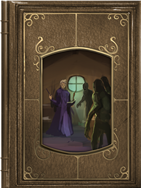

In [39]:
from IPython.display import Image

activity_version_id = girder_connection.get(
    "&".join([
        "folder?parentId={}".format(
            activity_id
        ),
        "parentType=folder"
    ])
)[0]["_id"]
screen_id = girder_connection.get(
    "item?folderId={}".format(activity_version_id)
)[0]["_id"] # get Activity's first Screen's _id
girder_connection.downloadFile(
    fileId=girder_connection.get(
        "item/{}/files".format(screen_id)
    )[0]["_id"],
    path=os.path.join(
        os.getcwd(),
        girder_connection.get(
            "item/{}/files".format(screen_id)
        )[0]["name"]
    )
) # download the Image
Image(
    filename=os.path.join(
        os.getcwd(),
        girder_connection.get(
            "item/{}/files".format(screen_id)
        )[0]["name"]
    )
) # display the Image

# create Screens

## select Activity to house Screens under

In [ ]:
activity_id = girder_connection.post(
    "&".join([
        "folder?name={}".format(activity_name),
        "parentId={}".format(activities_id),
        "parentType=folder",
        "reuseExisting=true"
    ])
)["_id"] # create or find the Activity Folder in the relevant Volume.Activities; store the _id to a variable

activity_version_id = girder_connection.get(
    "&".join([
        "folder?parentType=folder",
        "parentId={}".format(activity_id),
        "sort=updated",
        "sortdir=-1"
    ])
)[0]["_id"] # get newest version

## create 2 screens, the second depending on the first not being "never"

In [ ]:
screens_ids = []
screen_short = "gg_effects_delay_venom"
screen_long = "How long until you feel the effects of slow-moving venom?"
screen_name = ": ".join([
    screen_short,
    screen_long
])
meta = {
    '@context': {
        '@base': 'http://localhost:8080/api/v1/',
        'devices': 'http://www.w3id.org/abdn/irp/devices/',
        'nidm': 'http://nidm.nidash.org/specs/nidm-experiment.html#',
        'oslc': 'http://open-services.net/ns/core#',
        'pav': 'http://purl.org/pav/',
        'pav:lastUpdatedOn': {'@type': 'xsd:dateTime'},
        'schema': 'http://schema.org/',
        'schema:description': {'@type': 'xsd:string'},
        'schema:name': {'@type': 'xsd:string'},
        'xsd': 'http://www.w3.org/2001/XMLSchema'
    },
        'question_text': {
            '@language': 'en-US',
            '@value': screen_long
        },
        'response_type': 'single_sel',
        'options': [
            {
                'option_text': {
                    '@language': 'en-UK',
                    '@value': 'immediately'
                },
                'value': 0
            },
            {
                'option_text': {
                    '@language': 'en-UK',
                    '@value': 'not immediately, but within a week'
                },
                'value': 1
            },
            {
                'option_text': {
                    '@language': 'en-UK',
                    '@value': 'not within a week, but eventually'
                },
                'value': 2
            },
            {
                'option_text': {
                    '@language': 'en-UK',
                    '@value': 'never'
                },
                'value': None
            }
        ],
        'schema:name': {
            '@language': 'en-UK',
            '@value': screen_short
        }
}
screens_ids.append(
    girder_connection.post(
        "&".join([
            "item?name={}".format(
                screen_name
            ),
            "folderId={}".format(activity_version_id),
            "reuseExisting=true",
            "metadata={}".format(
                quote(
                    json.dumps(
                        meta
                    )
                )
            )
        ])
    )["_id"] # create a Screen in the Activity Version Folder; store the _id to a variable
)
screen_short = "gg_effects_of_venom"
screen_long = "What were the effects of the venom?"
screen_name = ": ".join([
    screen_short,
    screen_long
])
meta = {
    '@context': {
        '@base': 'http://localhost:8080/api/v1/',
        'devices': 'http://www.w3id.org/abdn/irp/devices/',
        'nidm': 'http://nidm.nidash.org/specs/nidm-experiment.html#',
        'oslc': 'http://open-services.net/ns/core#',
        'pav': 'http://purl.org/pav/',
        'pav:lastUpdatedOn': {'@type': 'xsd:dateTime'},
        'schema': 'http://schema.org/',
        'schema:description': {'@type': 'xsd:string'},
        'schema:name': {'@type': 'xsd:string'},
        'xsd': 'http://www.w3.org/2001/XMLSchema'
    },
        'question_text': {
            '@language': 'en-US',
            '@value': screen_long
        },
        'response_type': 'text',
        'schema:name': {
            '@language': 'en-UK',
            '@value': screen_short
        }
}
screens_ids.append(
    girder_connection.post(
        "&".join([
            "item?name={}".format(
                screen_name
            ),
            "folderId={}".format(activity_version_id),
            "reuseExisting=true",
            "metadata={}".format(
                quote(
                    json.dumps(
                        meta
                    )
                )
            )
        ])
    )["_id"] # create a Screen in the Activity Version Folder; store the _id to a variable
)

## Create default sequence

In [ ]:
meta = girder_connection.get(
    "folder/{}".format(activity_version_id)
)["meta"]

meta["screens"] = [
    {
        "@id": "item/{}".format(screens_ids[0])
    }
]

girder_connection.put(
    "?".join([
        "folder/{}".format(activity_version_id),
        "metadata={}".format(
            quote(
                json.dumps(
                    meta
                )
            )
        )
    ])
)

## Add conditional logic to first screen

In [ ]:
meta = girder_connection.get(
    "item/{}".format(screens_ids[0])
)["meta"]
meta['options'] = [
    *[
        {
            **option,
            'next_screen': {
                "@id": "item/{}".format(
                    screens_ids[1]
                )
            }
        } for option in meta['options'] if option['value'] is not None
    ],
    *[
        option for option in meta['options'] if option['value'] is None
    ]
]

girder_connection.put(
    "?".join([
        "item/{}".format(screens_ids[0]),
        "metadata={}".format(
            quote(
                json.dumps(
                    meta
                )
            )
        )
    ])
)